slice(None, None, None)
slice(None, None, None)
slice(None, None, None)


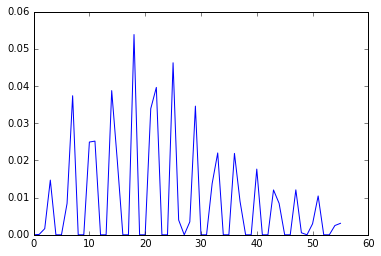

slice(None, None, None)
slice(None, None, None)
slice(None, None, None)


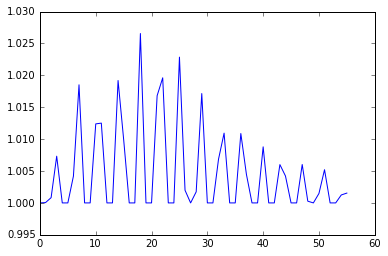

(26, 100, 300)


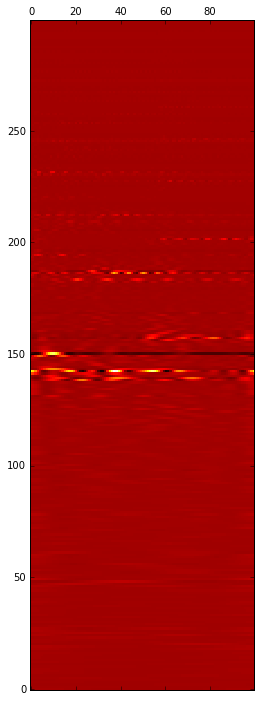

In [114]:
%matplotlib inline
from zounds import \
    AudioSamples,SR11025, Seconds, SampleRate, TimeSlice, \
    LinearScale, ArrayWithUnits, FrequencyDimension, \
    FrequencyAdaptiveTransform, GeometricScale, \
    FrequencyAdaptiveDCTSynthesizer, log_modulus
from zounds.soundfile import resample
from zounds.spectral import fft
import numpy as np
from IPython.display import Audio
from matplotlib import pyplot as plt
from scipy.fftpack import dct, idct
from scipy.signal import correlate

samplerate = SR11025()
chunk_size_samples = 8192

# TODO: write a test that exposes the segfault when trying to 
# resample a stereo file
samples = AudioSamples.from_file('../audio/bach.ogg')
samples = resample(samples.mono[:Seconds(10)], samplerate)


# TODO: Ideally, this would be one or two lines of code
window_rate = SampleRate(
    duration=samplerate.frequency * chunk_size_samples, 
    frequency=samplerate.frequency * (chunk_size_samples // 2))

freq = TimeSlice(duration=window_rate.frequency)
duration = TimeSlice(duration=window_rate.duration)

_, windowed = samples.sliding_window_with_leftovers(
    duration, freq, dopad=True)


# Move dct over into functional as well, so that I don't have to re-apply
# ArrayWithUnits here
coeffs = dct(windowed, norm='ortho')
scale = LinearScale.from_sample_rate(samplerate, coeffs.shape[-1], always_even=True)
coeffs = ArrayWithUnits(
    coeffs, [windowed.dimensions[0], FrequencyDimension(scale)])

geometric_scale = GeometricScale(
    start_center_hz=50,
    stop_center_hz=samplerate.nyquist,
    bandwidth_ratio=0.0315,
    n_bands=300,
    always_even=True)
geometric_scale.ensure_overlap_ratio(0.5)

# TODO: move the frequency adaptive transform into the functional module
fat = FrequencyAdaptiveTransform(
    transform=idct,
    scale=geometric_scale,
    window_func=np.hanning)
fa = list(fat._process(coeffs))[0]

# half-wave rectification
fa = np.clip(fa, 0, None)

plt.plot(fa[11, geometric_scale[201]])
plt.show()

# compression
fa = np.sqrt(1 + fa)

# TODO: low pass filtering


plt.plot(fa[11, geometric_scale[201]])
plt.show()

synth = FrequencyAdaptiveDCTSynthesizer(geometric_scale, samplerate)
recon = synth.synthesize(fa)


rasterized = fa.square(100)
print rasterized.shape
plt.matshow(log_modulus(np.abs(rasterized[10]).T * 100), origin='lower', cmap='hot')
plt.show()


for band in geometric_scale:
    z = fa[10, band]
    ac = correlate(z, z, mode='same')
    

Audio(recon, rate=int(samplerate))